In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import csv
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError
from pillow_heif import register_heif_opener
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import joblib

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

In [5]:
#Create an ml neural network that reads cursive letters

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [9]:
register_heif_opener()

path = "Cursive"
rows = []

#Recieved and data from text folder and converted to csv file
for dirpath, _, filenames in os.walk(path):
    label = os.path.basename(dirpath)
    for filename in filenames:
        filepath = os.path.abspath(os.path.join(dirpath, filename))
        try:
            with Image.open(filepath) as img:
                width, height = img.size
            size_kb = os.path.getsize(filepath) / 1024
            rows.append([label, filepath, width, height, size_kb])
        except UnidentifiedImageError:
            print(f"Skipping unreadable file: {filepath}")

#Recieved and read the data from the csv file using pandas
data = pd.DataFrame(rows, columns=['Label', 'FilePath', 'Width', 'Height', 'FileSizeKB'])
data.to_csv("Cursive.csv", index=False)

data.head()

,Label,FilePath,Width,Height,FileSizeKB
0,S19,/home/jupyter-260721/Machine-Learning-AI-Class...,1501,1127,896.290039
1,S19,/home/jupyter-260721/Machine-Learning-AI-Class...,1270,1047,648.894531
2,S19,/home/jupyter-260721/Machine-Learning-AI-Class...,1564,1144,975.461914
3,S19,/home/jupyter-260721/Machine-Learning-AI-Class...,2099,1482,1760.179688
4,S19,/home/jupyter-260721/Machine-Learning-AI-Class...,1449,1147,923.542969


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

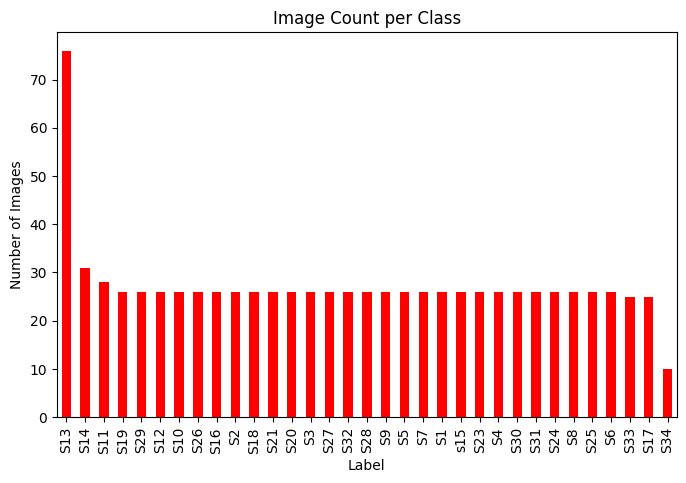

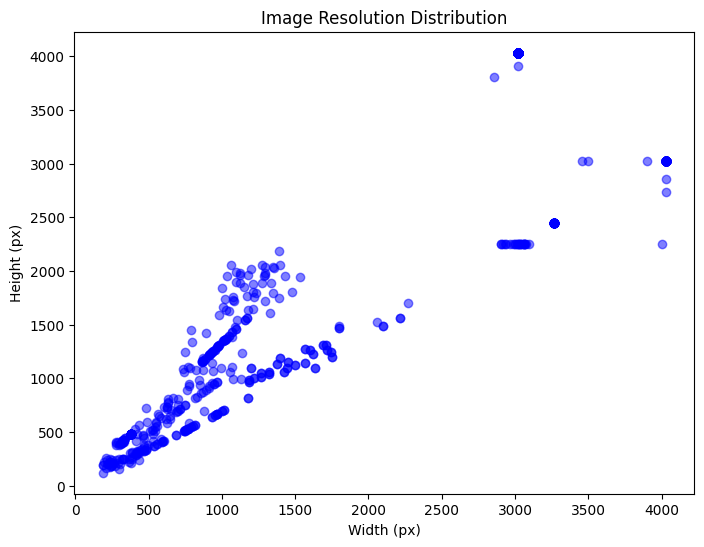

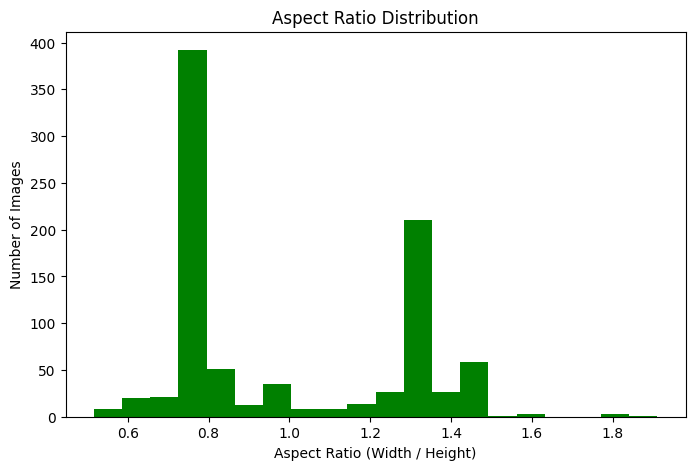

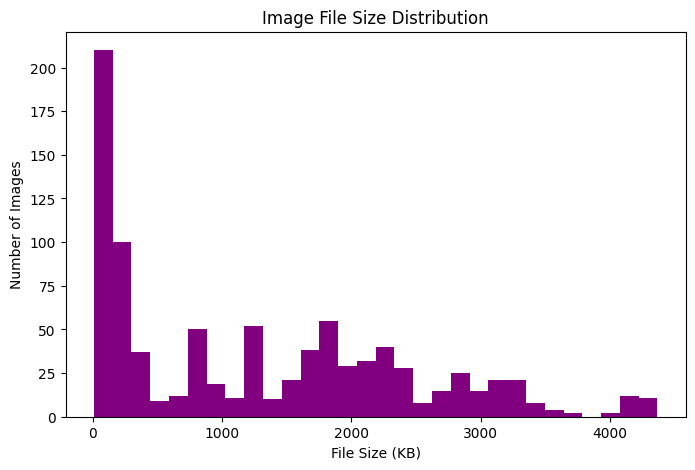

In [10]:

#Checks image count per label
plt.figure(figsize=(8,5))
data['Label'].value_counts().plot(kind='bar', color='red')
plt.ylabel('Number of Images')
plt.title('Image Count per Class')
plt.show()

#Checks height and width of images 
plt.figure(figsize=(8,6))
plt.scatter(data['Width'], data['Height'], alpha=0.5, color='blue')
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')
plt.title('Image Resolution Distribution')
plt.show()

#Checks aspect ratio of images
data['AspectRatio'] = data['Width'] / data['Height']
plt.figure(figsize=(8,5))
plt.hist(data['AspectRatio'], bins=20, color='green')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Number of Images')
plt.title('Aspect Ratio Distribution')
plt.show()

#Checks file size of images
plt.figure(figsize=(8,5))
plt.hist(data['FileSizeKB'], bins=30, color='purple')
plt.xlabel('File Size (KB)')
plt.ylabel('Number of Images')
plt.title('Image File Size Distribution')
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [11]:
# Converts and transforms the data to variables for training  
x, y = [], []

# Grayscales the images and converts them to numpy
for _, row in data.iterrows():
    with Image.open(row['FilePath']) as img:
        img = img.convert('L').resize((128, 128))  
        x.append(np.array(img))
    y.append(row['Label'])

x = np.array(x, dtype='float32') / 255.0 

x = np.expand_dims(x, axis=-1)

# Creates labels for the data
le = LabelEncoder()
y = le.fit_transform(y)

# Splits the data for training and testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


# Converts the data to tensors using torch
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2) 
X_test_tensor  = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [24]:
# Trying the sequential neural network to detect cursive
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),                           
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),                           
    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 64),               
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, len(le.classes_))              
)

criterion = nn.CrossEntropyLoss()              
optimizer = optim.Adam(model.parameters(), lr=0.001)
                       
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

#Saves the model
joblib.dump(model, "Base Model.joblib")
print("Model Saved")

Epoch 1/20 - Loss: 3.4973
Epoch 2/20 - Loss: 3.1078
Epoch 3/20 - Loss: 2.5148
Epoch 4/20 - Loss: 2.0941
Epoch 5/20 - Loss: 1.8195
Epoch 6/20 - Loss: 1.5594
Epoch 7/20 - Loss: 1.4277
Epoch 8/20 - Loss: 1.2867
Epoch 9/20 - Loss: 1.2244
Epoch 10/20 - Loss: 1.1585
Epoch 11/20 - Loss: 1.1232
Epoch 12/20 - Loss: 1.0265
Epoch 13/20 - Loss: 0.9913
Epoch 14/20 - Loss: 0.9549
Epoch 15/20 - Loss: 0.8944
Epoch 16/20 - Loss: 0.8488
Epoch 17/20 - Loss: 0.7941
Epoch 18/20 - Loss: 0.7971
Epoch 19/20 - Loss: 0.7621
Epoch 20/20 - Loss: 0.8149
Test Accuracy: 76.11%
Model Saved


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best results possiable 


In [26]:
# Adding epochs and changing parameters to see if accuracy changes 
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),   
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(64 * 32 * 32, 128),               
    nn.ReLU(),
    nn.Dropout(0.4),                            
    nn.Linear(128, len(le.classes_))              
)

criterion = nn.CrossEntropyLoss()              
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) 

epochs = 30  

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

joblib.dump(model, "Fine Tuned Model.joblib")
print("Model Saved")

Epoch 1/30 - Loss: 3.5355
Epoch 2/30 - Loss: 3.3079
Epoch 3/30 - Loss: 3.0126
Epoch 4/30 - Loss: 2.6306
Epoch 5/30 - Loss: 2.1366
Epoch 6/30 - Loss: 1.7017
Epoch 7/30 - Loss: 1.3396
Epoch 8/30 - Loss: 1.2615
Epoch 9/30 - Loss: 1.0993
Epoch 10/30 - Loss: 0.9644
Epoch 11/30 - Loss: 0.9165
Epoch 12/30 - Loss: 0.8613
Epoch 13/30 - Loss: 0.7943
Epoch 14/30 - Loss: 0.6899
Epoch 15/30 - Loss: 0.5960
Epoch 16/30 - Loss: 0.6401
Epoch 17/30 - Loss: 0.5735
Epoch 18/30 - Loss: 0.6033
Epoch 19/30 - Loss: 0.5915
Epoch 20/30 - Loss: 0.4917
Epoch 21/30 - Loss: 0.5306
Epoch 22/30 - Loss: 0.4611
Epoch 23/30 - Loss: 0.4753
Epoch 24/30 - Loss: 0.4196
Epoch 25/30 - Loss: 0.4555
Epoch 26/30 - Loss: 0.4513
Epoch 27/30 - Loss: 0.4046
Epoch 28/30 - Loss: 0.3860
Epoch 29/30 - Loss: 0.3728
Epoch 30/30 - Loss: 0.3260
Test Accuracy: 81.11%
Model Saved
